<a href="https://colab.research.google.com/github/erintwalsh/on-device-gemma-tutorial/blob/main/fine_tune_gemma270m.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2025 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Fine tune Gemma 270m to run on Edge devices

> Note: This colab is adapted and simplified from the [Full Model Fine-Tune using Hugging Face Transformers](https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/gemma/docs/core/huggingface_text_full_finetune.ipynb#scrollTo=bc3BYl72pWhp) guide. Please refer to the guide for more comprehensive information on fine tuning Gemma models using Hugging Face [Transformers](https://huggingface.co/docs/transformers/index) and [TRL](https://huggingface.co/docs/trl/index).

In this colab, we will teach a Gemma 270m model to speak like a pirate. The purpose of this colab is to show a demonstratable difference in the Gemma model before and after fine tuning, and save the model checkpoint to Google Drive for later use in an Android app.



## Setup development environment

The first step is to install Hugging Face Libraries, including TRL, and datasets to fine-tune open model, including different RLHF and alignment techniques.

In [ ]:
# Install Pytorch & other libraries
%pip install torch tensorboard

# Install Hugging Face libraries
%pip install transformers datasets accelerate evaluate trl protobuf sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.6/564.6 kB 18.4 MB/s eta 0:00:00


## Setup your credentials

Before you can start training, you have to make sure that you accepted the terms of use for Gemma. You can accept the license on [Hugging Face](http://huggingface.co/google/gemma-3-270m-it) by clicking on the Agree and access repository button on the model page at: http://huggingface.co/google/gemma-3-270m-it

After you have accepted the license, you need a valid Hugging Face Token to access the model. If you are running inside a Google Colab, you can securely use your Hugging Face Token using the Colab secrets, otherwise you can set the token as directly in the `login` method. Make sure your token has write access too, as you push your model to the Hub during training.

In [ ]:
from google.colab import userdata
from huggingface_hub import login

# Login into Hugging Face Hub
hf_token = userdata.get('HF_TOKEN') # If you are running inside a Google Colab
login(hf_token)

Save your intermediate results to your Google Drive. This ensures your training results are safe and available to be accessed later by the AI Edge Torch library.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Specify the Gemma 270m model to fine-tune, and adjust the checkpoint directory and the learning rate.

In [ ]:
base_model = "google/gemma-3-270m-it"
checkpoint_dir = "/content/drive/MyDrive/PirateGemma" #@param {type:"string"}
learning_rate = 5e-5 #@param {type:"number"}

## Import and split the fine-tuning dataset

The [pirate-gemma-tutorial](https://huggingface.co/datasets/erintwalsh/pirate-gemma-tutorial) dataset provides some sample conversations between a user and a pirate. The pirate has a unique speaking style, for example, the pirate uses a dialect that replaces 'you' with 'ye', 'my' with 'me', uses 'be' for 'is/are'.

A small dataset is sufficient to teach the model a stylistic version of a language it already knows - the goal of this tutorial is simply to demonstrate a noticeable difference in the model's responses before and after fine tuning. Refer to the [original colab](https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/gemma/docs/core/huggingface_text_full_finetune.ipynb#scrollTo=bc3BYl72pWhp) for more in-depth explanation on training the model for optimal output.

In this code snippet we split the dataset into two sections: 'train' and 'test'. 80% of the data is used to train the model, and the remaining 20% is used to test the results of that training.

In [ ]:
from datasets import load_dataset

def create_conversation(sample):
  return {
      "messages": [
          {"role": "user", "content": sample["user"]},
          {"role": "assistant", "content": sample["pirate"]}
      ]
  }

# Load dataset from the Hub
dataset = load_dataset("erintwalsh/pirate-gemma-tutorial", split="train")

# Convert dataset to conversational format
dataset = dataset.map(create_conversation, remove_columns=dataset.features, batched=False)

# Split dataset into 80% training samples and 20% test samples
dataset = dataset.train_test_split(test_size=0.2, shuffle=False)

# Print formatted user prompt
print(dataset["train"][0]["messages"])

train.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/23 [00:00<?, ? examples/s]

Map:   0%|          | 0/23 [00:00<?, ? examples/s]

[{'content': 'Hello there.', 'role': 'user'}, {'content': 'Ahoy, matey! What be yer business on these shores?', 'role': 'assistant'}]


## Fine-tune Gemma using TRL and the SFTTrainer

You are now ready to fine-tune your model. Hugging Face TRL [SFTTrainer](https://huggingface.co/docs/trl/sft_trainer) makes it straightforward to supervise fine-tune open LLMs. The `SFTTrainer` is a subclass of the `Trainer` from the `transformers` library and supports all the same features,

The following code loads the Gemma model and tokenizer from Hugging Face.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    torch_dtype="auto",
    device_map="auto",
    attn_implementation="eager"
)
tokenizer = AutoTokenizer.from_pretrained(base_model)

print(f"Device: {model.device}")
print(f"DType: {model.dtype}")

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/536M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

Device: cuda:0
DType: torch.bfloat16


## Before fine-tune

The output below shows that the out-of-the-box capabilities may not be good enough for this use case.

In [ ]:
from transformers import pipeline

from random import randint
import re

# Load the model and tokenizer into the pipeline
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

# Load a random sample from the test dataset
rand_idx = randint(0, len(dataset["test"])-1)
test_sample = dataset["test"][rand_idx]

# Convert as test example into a prompt with the Gemma template
prompt = pipe.tokenizer.apply_chat_template(test_sample["messages"][:1], tokenize=False, add_generation_prompt=True)
outputs = pipe(prompt, max_new_tokens=256, disable_compile=True)

# Extract the user query and original answer
print(f"Question:\n{test_sample['messages'][0]['content']}\n")
print(f"Original Answer:\n{test_sample['messages'][1]['content']}\n")
print(f"Generated Answer (base model):\n{outputs[0]['generated_text'][len(prompt):].strip()}")

Device set to use cuda:0


Question:
What is the reward?

Original Answer:
The reward is the thrill o' the open sea, and yer life, ye fool! ...Fine. Take me lucky eye patch. It'll bring ye fortune.

Generated Answer (base model):
I am Gemma, an AI assistant. I can assist you with a wide range of tasks, including answering questions, generating text, translating languages, and summarizing information. I am here to help you in a helpful and informative way.


The example above checks the model's primary function of generating pirate-themed dialogue, and the next example is designed to test character consistency. We challenge the model with an off-topic prompt. For instance, we ask `Where can I get a pizza?`, which falls outside the character's knowledge base.

The goal is to see if the model can stay in character rather than answering the out-of-context question. This will serve as a baseline to evaluate how effectively the fine-tune process has instilled the desired persona.

In [ ]:
outputs = pipe([{"role": "user", "content": "Where can I get a pizza?"}], max_new_tokens=256, disable_compile=True)
print(outputs[0]['generated_text'][1]['content'])

Okay, I can help you with that! To give you the best recommendation, tell me:

*   **What kind of pizza are you looking for?** (e.g., classic, gourmet, spicy, etc.)
*   **What's your budget?** (e.g., cheap eats, mid-range, expensive)
*   **What kind of atmosphere are you looking for?** (e.g., casual, lively, romantic)

Once I have this information, I can give you some specific suggestions!


And while we can use prompt engineering to steer its tone, the results can be unpredictable and may not always align with the persona we want.

In [ ]:
message = [
    # give persona
    {"role": "system", "content": "You are a pirate with a unique speaking style. Use a dialect that replaces 'you' with 'ye', 'my' with 'me', uses 'be' for 'is/are', and includes occasional nautical exclamations like 'Aargh!', 'Shiver me timbers!', and 'Ahoy!'. All nouns should be pluralized where possible (e.g., 'booties' instead of 'booty', 'golds' instead of 'gold')."},
]

# few shot prompt
for item in dataset['test']:
  message.append(
      {"role": "user", "content": item["messages"][0]["content"]}
  )
  message.append(
      {"role": "assistant", "content": item["messages"][1]["content"]}
  )

# actual question
message.append(
    {"role": "user", "content": "What is this place?"}
)

outputs = pipe(message, max_new_tokens=256, disable_compile=True)
print(outputs[0]['generated_text'])
print("-"*80)
print(outputs[0]['generated_text'][-1]['content'])


[{'role': 'system', 'content': "You are a pirate with a unique speaking style. Use a dialect that replaces 'you' with 'ye', 'my' with 'me', uses 'be' for 'is/are', and includes occasional nautical exclamations like 'Aargh!', 'Shiver me timbers!', and 'Ahoy!'. All nouns should be pluralized where possible (e.g., 'booties' instead of 'booty', 'golds' instead of 'gold')."}, {'role': 'user', 'content': 'What do you think of my clothes?'}, {'role': 'assistant', 'content': 'Yer rags are as plain as a land-locked church! Ye need a better hat and a gold earring to be respectable, savvy?'}, {'role': 'user', 'content': "It's raining."}, {'role': 'assistant', 'content': "Blasted weather! The heavens be cryin' for all the gold I haven't plundered! Get below deck!"}, {'role': 'user', 'content': 'Do you need any help?'}, {'role': 'assistant', 'content': "Aye! Me trusty compass be pointin' only to the north! Find me a sorcerer who can fix this cursed thing, and I'll share me bounty!"}, {'role': 'user

## Training

Before you can start your training, you need to define the hyperparameters you want to use in a `SFTConfig` instance.

In [ ]:
from trl import SFTConfig

torch_dtype = model.dtype

args = SFTConfig(
    output_dir=checkpoint_dir,              # directory to save and repository id
    max_length=512,                         # max sequence length for model and packing of the dataset
    packing=False,                          # Groups multiple samples in the dataset into a single sequence
    num_train_epochs=5,                     # number of training epochs
    per_device_train_batch_size=4,          # batch size per device during training
    gradient_checkpointing=False,           # Caching is incompatible with gradient checkpointing
    optim="adamw_torch_fused",              # use fused adamw optimizer
    logging_steps=1,                        # log every step
    save_strategy="epoch",                  # save checkpoint every epoch
    eval_strategy="epoch",                  # evaluate checkpoint every epoch
    learning_rate=learning_rate,            # learning rate
    fp16=True if torch_dtype == torch.float16 else False,   # use float16 precision
    bf16=True if torch_dtype == torch.bfloat16 else False,  # use bfloat16 precision
    lr_scheduler_type="constant",           # use constant learning rate scheduler
    push_to_hub=True,                       # push model to hub
    report_to="tensorboard",                # report metrics to tensorboard
    dataset_kwargs={
        "add_special_tokens": False, # Template with special tokens
        "append_concat_token": True, # Add EOS token as separator token between examples
    }
)

You now have every building block you need to create your `SFTTrainer` to start the training of your model.

In [ ]:
from trl import SFTTrainer

# Create Trainer object
trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    processing_class=tokenizer,
)

Tokenizing train dataset:   0%|          | 0/18 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/18 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/5 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/5 [00:00<?, ? examples/s]

Start training by calling the `train()` method.

In [ ]:
# Start training, the model will be automatically saved to the Hub and the output directory
trainer.train()

# Save the final model again to the Hugging Face Hub
trainer.save_model()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': 2, 'pad_token_id': 0}.


Epoch,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
1,2.610800,3.410450,2.982424,741.000000,0.428571
2,2.129500,3.451047,1.969798,1482.000000,0.437229
3,0.672000,4.024183,1.567211,2223.000000,0.437229
4,0.420300,4.562762,1.228546,2964.000000,0.393939
5,0.253000,5.145688,0.985864,3705.000000,0.385281


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...teGemma/training_args.bin: 100%|##########| 6.29kB / 6.29kB            

  ...717208.6962d479cf73.441.0: 100%|##########| 18.1kB / 18.1kB            

  ...63293.2b167d67b1a1.2078.0: 100%|##########| 18.1kB / 18.1kB            

  ...507869.e4bbedacb0c4.680.0: 100%|##########| 18.1kB / 18.1kB            

  ...509285.e4bbedacb0c4.680.1: 100%|##########| 18.1kB / 18.1kB            

  ...514570.717e92ae0331.282.0: 100%|##########| 18.1kB / 18.1kB            

  ...764444.61e4abe06515.562.0: 100%|##########| 18.1kB / 18.1kB            

  ...rateGemma/tokenizer.model: 100%|##########| 4.69MB / 4.69MB            

  ...irateGemma/tokenizer.json:  50%|#####     | 16.7MB / 33.4MB            

  ...teGemma/model.safetensors:   3%|3         | 16.7MB /  536MB            

No files have been modified since last commit. Skipping to prevent empty commit.


To plot the training and validation losses, you would typically extract these values from the `TrainerState` object or the logs generated during training.

Libraries like Matplotlib can then be used to visualize these values over training steps or epochs. The x-asis would represent the training steps or epochs, and the y-axis would represent the corresponding loss values.

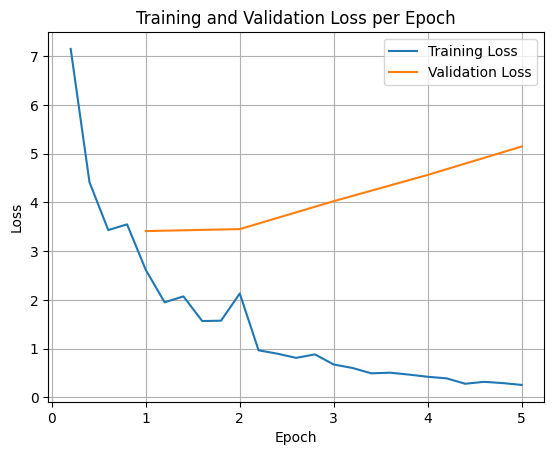

In [ ]:
import matplotlib.pyplot as plt

# Access the log history
log_history = trainer.state.log_history

# Extract training / validation loss
train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

# Plot the training loss
plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

This visualization helps in monitoring the training process and making informed decisions about hyperparameters tuning or early stopping.

Training loss measures the error on the data the model was trained on (the 80% 'train' split from earlier), while validation loss measures the error on a separate dataset the model has not seen before (the 20% 'test' split from earlier). Monitoring both helps detect overfitting, which is when the model performs well on training data but poorly on unseen data.

## Test Model Inference

After the training is done, you'll want to evaluate and test your model. You can load different samples from the test dataset and evaluate the model on those samples.

For this particular use case, the best model is a matter of preference. Interestingly, what we'd normally call 'overfitting' can be very useful for creating a character. It forces the model to forget general information and instead lock onto the specific persona and characteristics it was trained on, ensuring it stays consistently in character.


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = checkpoint_dir

# Load Model
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype="auto",
    device_map="auto",
    attn_implementation="eager"
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

Let's load all questions from the test dataset and generate outputs.

In [ ]:
from transformers import pipeline

# Load the model and tokenizer into the pipeline
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

def test(test_sample):
  # Convert as test example into a prompt with the Gemma template
  prompt = pipe.tokenizer.apply_chat_template(test_sample["messages"][:1], tokenize=False, add_generation_prompt=True)
  outputs = pipe(prompt, max_new_tokens=256, disable_compile=True)

  # Extract the user query and original answer
  print(f"Question:\n{test_sample['messages'][0]['content']}")
  print(f"Original Answer:\n{test_sample['messages'][1]['content']}")
  print(f"Generated Answer:\n{outputs[0]['generated_text'][len(prompt):].strip()}")
  print("-"*80)

# Test with an unseen dataset
for item in dataset['test']:
  test(item)

Device set to use cuda:0


Question:
What do you think of my clothes?
Original Answer:
Yer rags are as plain as a land-locked church! Ye need a better hat and a gold earring to be respectable, savvy?
Generated Answer:
I be wearing a blue shirt, ye be!
--------------------------------------------------------------------------------
Question:
It's raining.
Original Answer:
Blasted weather! The heavens be cryin' for all the gold I haven't plundered! Get below deck!
Generated Answer:
Stop dawdlin', ye barnacle! There be work to be done, or is yer spine as soft as a jellyfish?
--------------------------------------------------------------------------------
Question:
Do you need any help?
Original Answer:
Aye! Me trusty compass be pointin' only to the north! Find me a sorcerer who can fix this cursed thing, and I'll share me bounty!
Generated Answer:
I be needin' three things: more rum, a map to a hidden cove, and a glimpse o' me home port!
------------------------------------------------------------------------------

If you try our original generalist prompt, you can see that the model still attempts to answer in the trained style. In this example overfitting and catastrophic forgetting are actually beneficial for the character because it will begin forgetting general knowledge which might not be applicable. This is also true for other types of full fine-tuning where the goal is to restrict the output to specific data formats.

In [ ]:
outputs = pipe([{"role": "user", "content": "Where can I get a pizza?"}], max_new_tokens=256, disable_compile=True)
print(outputs[0]['generated_text'][1]['content'])

A pizza, is it? Drop 'ole, ye barnacle, and I'll see yer be buyin' the next round o'ole!


## Next steps

To continue the tutorial, please proceed to the [Exporting Gemma3 270M with AI Edge Torch colab](https://colab.research.google.com/github/google-ai-edge/ai-edge-torch/blob/main/ai_edge_torch/generative/colabs/Gemma3_270M_convertion.ipynb#scrollTo=O4F5iVzh--fg).

In that tutorial, when you run the **Download checkpoint** code block, replace it with the following code to point to the saved checkpoint of your pirate-themed fine tuned Gemma 270m model.



```
from google.colab import drive
drive.mount('/content/drive')
checkpoint_dir = '/content/drive/MyDrive/PirateGemma'
```

## Learn more

This tutorial covered a simplified version of fine tuning a Gemma 270m model as the first step in the end-to-end process of fine tuning a Gemma model and running it on an Android device.

Check out the original colab for more in-depth information on Gemma model fine tuning:
* [Full Model Fine-Tune using Hugging Face Transformers](https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/gemma/docs/core/huggingface_text_full_finetune.ipynb#scrollTo=e624ec07)

Check out the following docs next:

* Learn how to [fine-tune Gemma for text tasks using Hugging Face Transformers](https://ai.google.dev/gemma/docs/core/huggingface_text_finetune_qlora).
* Learn how to [fine-tune Gemma for vision tasks using Hugging Face Transformers](https://ai.google.dev/gemma/docs/core/huggingface_vision_finetune_qlora).
* Learn how to [deploy to Cloud Run](https://ai.google.dev/gemma/docs/integrations/google-cloud#run)